# Distance traveled analysis
## Mean movement for each fly in the group

F_onewayResult(statistic=22.18591429021347, pvalue=1.1407103621751864e-17)
      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj   lower   upper  reject
----------------------------------------------------------------
        CsCh      Cs_5DIZ  -0.9423    0.0 -1.4806 -0.4041   True
        CsCh     LDA_5DIZ    0.263 0.6288 -0.2508  0.7767  False
        CsCh LDA_OCT_5DIZ  -1.4768    0.0 -2.1222 -0.8314   True
        CsCh     OCT_5DIZ  -0.8844 0.0001 -1.4302 -0.3386   True
     Cs_5DIZ     LDA_5DIZ   1.2053    0.0  0.6723  1.7383   True
     Cs_5DIZ LDA_OCT_5DIZ  -0.5345 0.1768 -1.1954  0.1264  False
     Cs_5DIZ     OCT_5DIZ   0.0579 0.9986 -0.5061  0.6219  False
    LDA_5DIZ LDA_OCT_5DIZ  -1.7398    0.0 -2.3808 -1.0988   True
    LDA_5DIZ     OCT_5DIZ  -1.1474    0.0  -1.688 -0.6068   True
LDA_OCT_5DIZ     OCT_5DIZ   0.5924  0.109 -0.0746  1.2594  False
----------------------------------------------------------------


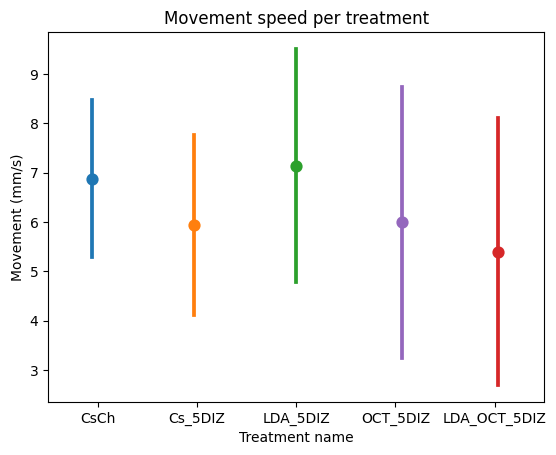

In [10]:
import os
import toml
import scipy.stats

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.stats.multicomp import pairwise_tukeyhsd

from src import settings
from src.utils import fileio

CONFIG_PATH = os.path.join(settings.CONFIG_DIR, "main.toml")
with open(CONFIG_PATH, "r") as file:
    config = toml.load(file)
    
TIME_WINDOW=config["TIME_WINDOW"]

INPUT_PATH = os.path.join(settings.RESULTS_DIR, "distances_traveled")

all_treatments = fileio.load_multiple_folders(INPUT_PATH)
all_treatments = {key: value for key, value in all_treatments.items() if key in config["TREATMENTS"]}

treatment_dataframes = []
for treatment_name, treatment_path in all_treatments.items():
    all_groups = fileio.load_files_from_folder(treatment_path)
    group_dataframes = []
    for group_name, df_path in all_groups.items():
        df = pd.read_csv(df_path, index_col=0)  
        df['Snapshot'] = (df.index / config["FPS"] / TIME_WINDOW).astype(int) + 1
        df['Group'] = group_name.replace(".csv","")

        group_dataframes.append(df)

    df = pd.concat(group_dataframes)
    df.set_index('Snapshot', inplace=True)
    df.set_index('Group', append=True, inplace=True)

    df['Treatment'] = treatment_name
    df.set_index('Treatment', append=True, inplace=True)
    df = df.reorder_levels(['Treatment', 'Group', 'Snapshot'])
  
    treatment_dataframes.append(df)
    
combined_data = pd.concat(treatment_dataframes)
combined_data_reset = combined_data.groupby(['Treatment', 'Group']).sum()
combined_data_reset = combined_data_reset.stack().reset_index().rename(columns={'level_2': 'Fly', 0: 'Distance'})
combined_data_reset['Distance'] = combined_data_reset['Distance']/config['EXPERIMENT_DURATION']

treatment_sums = {}
for treatment in config["TREATMENTS"]:
    treatment_sums[f'sum_{treatment}'] = combined_data_reset[combined_data_reset['Treatment'] == treatment]['Distance']

anova_result = scipy.stats.f_oneway(*treatment_sums.values())
print(f'{anova_result}')

all_data = np.concatenate([*treatment_sums.values()])
group_labels = []
for treatment in config["TREATMENTS"]:
    group_labels.extend([treatment] * len(combined_data_reset[combined_data_reset['Treatment'] == treatment]['Distance']))

tukey_results = pairwise_tukeyhsd(all_data, group_labels)

print(tukey_results)

sns.pointplot(data=combined_data_reset, x='Treatment', y='Distance', hue='Treatment', errorbar="sd", dodge=True, order=config["TREATMENTS"])

plt.title('Movement speed per treatment')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Treatment")
plt.xlabel("Treatment name")
plt.ylabel("Movement (mm/s)")
plt.legend().remove()